In [60]:
from main import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pdfplumber
import re
import os
import logging
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.ticker import NullLocator

logging.getLogger('pdfminer').setLevel(logging.ERROR)

In [61]:
receipts_path = "data/receipts"
receipts = [os.path.join(receipts_path, f) for f in os.listdir(receipts_path) if f.endswith('.pdf')]

all_receipts = []
all_products = []

for receipt in receipts:
    r, p = parse_receipt(receipt)
    all_receipts.append(r)
    all_products.append(p)

raw_receipts_df = pd.concat(all_receipts, ignore_index=True)
raw_products_df = pd.concat(all_products, ignore_index=True)

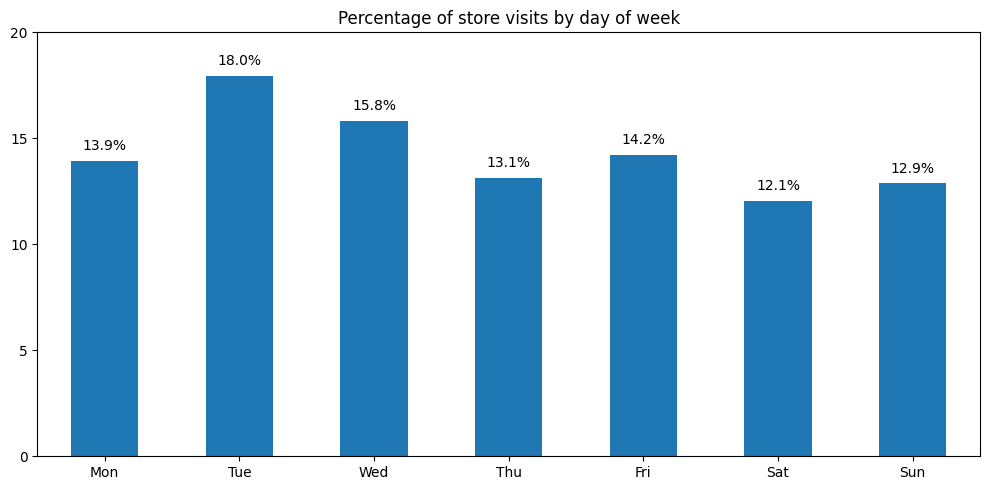

In [62]:
df = raw_receipts_df.copy()

plt.figure(figsize=(10, 5))
day_percentages = df.groupby(df['datetime'].dt.dayofweek).size() / len(df) * 100
ax = day_percentages.plot(kind='bar', title="Percentage of store visits by day of week")
plt.ylim(0, 20)
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
plt.yticks(range(0, 25, 5))
plt.xlabel("")

for i, v in enumerate(day_percentages):
    ax.text(i, v + 0.5, f'{v:.1f}%', ha='center')

plt.tight_layout()
plt.savefig('data/output/day_percentages.png', dpi=300)
plt.show()

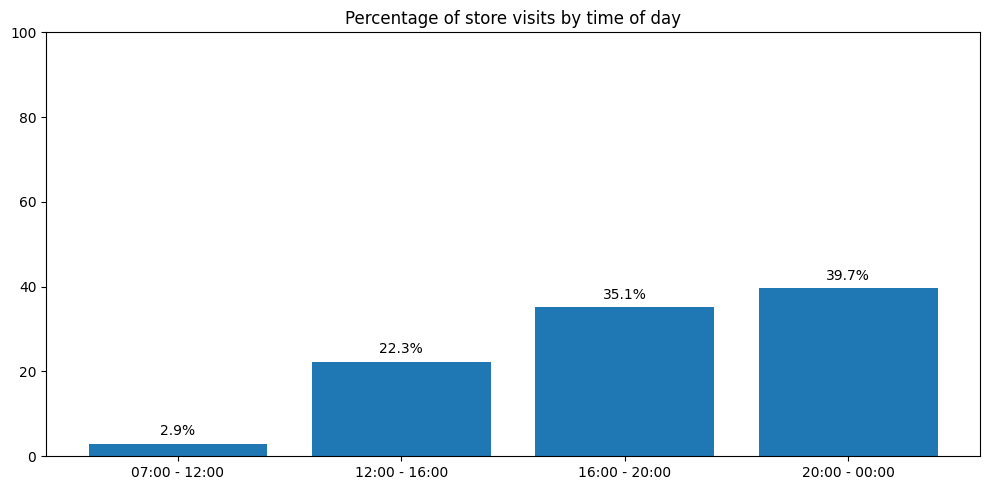

In [63]:
df = raw_receipts_df.copy()

times_of_day = {
    "07:00 - 12:00":[7,  12],
    "12:00 - 16:00":[12, 16], 
    "16:00 - 20:00":[16, 20],
    "20:00 - 00:00":[20, 24],
}

def map_tod(hr):
    for label, (start, end) in times_of_day.items():
        if start <= hr < end:
            return label
    return "other"

receipts_tod = df['datetime'].dt.hour.apply(map_tod)

tod_counts = receipts_tod.value_counts().reindex(times_of_day.keys())
tod_percentages    = tod_counts / tod_counts.sum() * 100

fig, ax = plt.subplots(figsize=(10,5))
ax.bar(tod_percentages.index, tod_percentages.values)
ax.set_ylim(0, 100)
ax.set_title("Percentage of store visits by time of day")
plt.xticks(range(4), ['07:00 - 12:00', '12:00 - 16:00', '16:00 - 20:00', '20:00 - 00:00'], rotation=0)

for i, v in enumerate(tod_percentages):
    ax.text(i, v + 2, f'{v:.1f}%', ha='center')

plt.tight_layout()
plt.savefig('data/output/time_of_day_percentages.png', dpi=300)
plt.show()

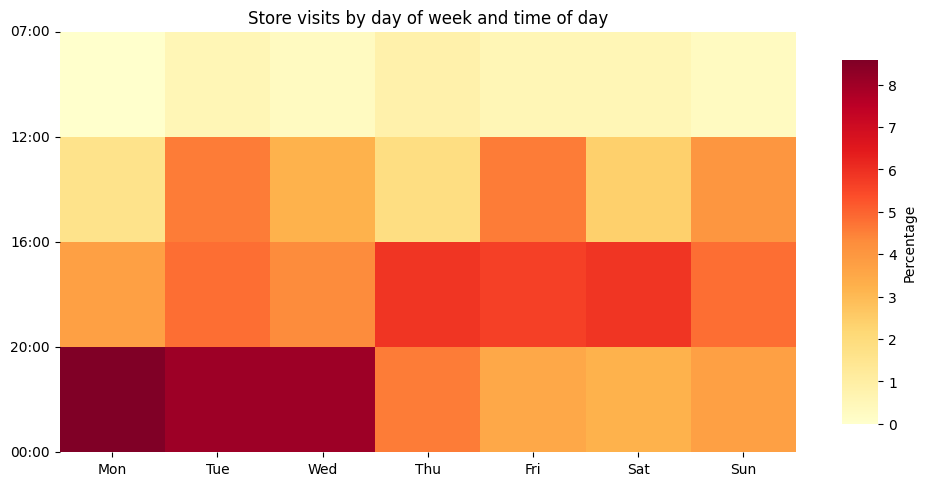

In [64]:
df = raw_receipts_df.copy()

df['day']         = df['datetime'].dt.strftime('%a')
df['time_of_day'] = df['datetime'].dt.hour.apply(map_tod)

pivot = df.pivot_table(
    index='time_of_day',
    columns='day',
    values='receipt_id',
    aggfunc='count',
    fill_value=0
)

days_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
times_order = ['07:00 - 12:00', '12:00 - 16:00', '16:00 - 20:00', '20:00 - 00:00']

pivot = pivot[days_order]
pivot = pivot.reindex(times_order)

pivot_pct = pivot / pivot.values.sum() * 100

plt.figure(figsize=(10,5))
ax = sns.heatmap(
    pivot_pct,
    cmap='YlOrRd',
    square=True,
    cbar_kws={
        'label':'Percentage',
        'shrink':0.8,
        'aspect':10
        }
)

edges = [t.split(' - ')[0] for t in times_order]
edges.append(times_order[-1].split(' - ')[1])

n = len(times_order)
ax.set_yticks(np.arange(n+1))
ax.set_yticklabels(edges, rotation=0)

ax.set_xticks(np.arange(len(days_order)) + 0.5)
ax.set_xticklabels(days_order, rotation=0)

plt.title('Store visits by day of week and time of day')
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.savefig('data/output/day_time_heatmap.png', dpi=300)
plt.show()

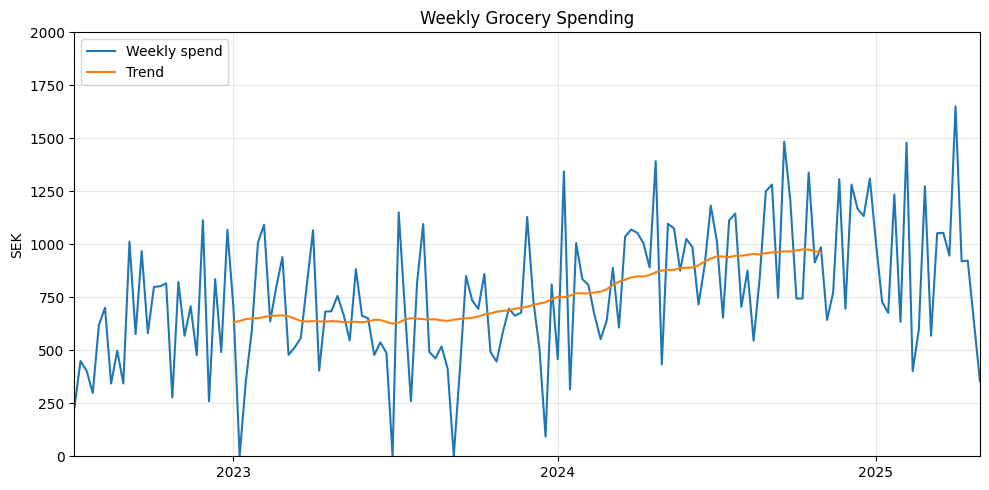

In [74]:
df = raw_receipts_df.copy()

fig, ax = plt.subplots(figsize=(10, 5))
weekly_spend = df.set_index('datetime')['total_amount'].resample('W').sum().plot(ax=ax, title="Weekly Grocery Spending", label='Weekly spend')
weekly_result = seasonal_decompose(df.set_index('datetime')['total_amount'].resample('W').sum(), model='additive', period=52)
weekly_result.trend.plot(ax=ax, label='Trend')

ax.set_ylim(bottom=0, top=2000)
ax.set_xlabel("")
ax.set_ylabel("SEK")
ax.legend(loc='upper left')

years = pd.date_range(start=df.datetime.min(), end=df.datetime.max(), freq='YS')
ax.set_xticks(years)
ax.set_xticklabels([d.strftime('%Y') for d in years])
ax.xaxis.set_minor_locator(plt.NullLocator())
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('data/output/weekly_spend.png', dpi=300)
plt.show()

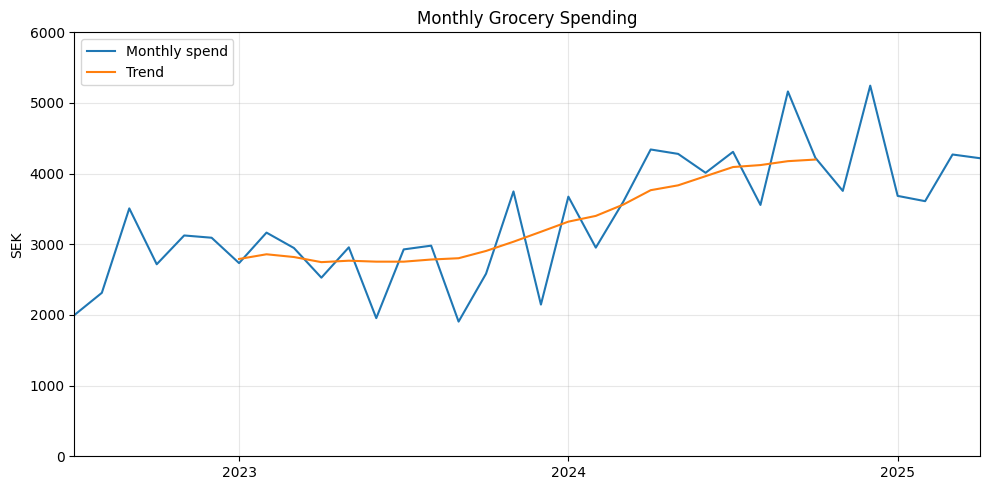

In [75]:
df = raw_receipts_df.copy()

fig, ax = plt.subplots(figsize=(10, 5))
monthly_spend = raw_receipts_df.set_index('datetime')['total_amount'].resample('ME').sum().plot(ax=ax, title="Monthly Grocery Spend", label='Monthly spend')
ax.set_ylim(bottom=0, top=6000)
ax.set_xlabel("")
ax.set_ylabel("SEK")

monthly = raw_receipts_df.set_index('datetime')['total_amount'].resample('ME').sum()
monthly_result = seasonal_decompose(monthly, model='additive', period=12)

monthly_result.trend.plot(ax=ax, title="Monthly Grocery Spending", label='Trend')
ax.set_ylim(bottom=0, top=6000)
ax.set_xlabel("")
ax.legend(loc='upper left')

years = pd.date_range(start=df.datetime.min(), end=df.datetime.max(), freq='YS')
ax.set_xticks(years)
ax.set_xticklabels([d.strftime('%Y') for d in years])
ax.xaxis.set_minor_locator(plt.NullLocator())
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('data/output/monthly_spend.png', dpi=300)
plt.show()

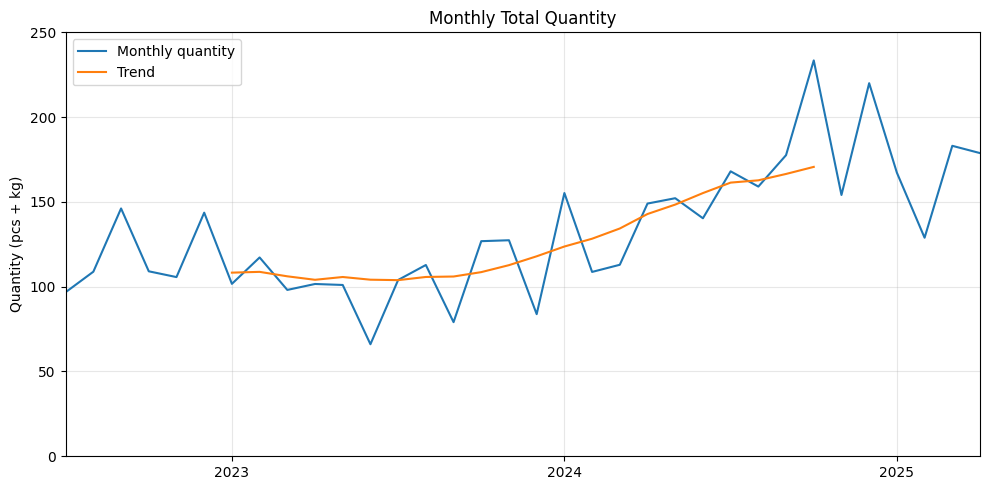

In [67]:
fig, ax = plt.subplots(figsize=(10, 5))

df = (
    raw_products_df
      .merge(
         raw_receipts_df[['receipt_id','datetime']],
         on='receipt_id', how='left'
      )
)

df['month'] = df['datetime'].dt.to_period('M').dt.to_timestamp()

monthly_qty = df.groupby('month')['quantity'].sum()

monthly_qty.plot(ax=ax, label='Monthly quantity')
monthly_result = seasonal_decompose(monthly_qty, model='additive', period=12)
monthly_result.trend.plot(ax=ax, label='Trend')

ax.set_ylabel('Quantity (pcs + kg)')
ax.set_title('Monthly Total Quantity')
ax.tick_params(axis='x', rotation=0)
ax.grid(alpha=0.3)
ax.legend(loc='upper left')

years = pd.date_range(start=df.datetime.min(), end=df.datetime.max(), freq='YS')
ax.set_xticks(years)
ax.set_xticklabels([d.strftime('%Y') for d in years])
ax.xaxis.set_minor_locator(plt.NullLocator())
ax.set_xlabel('')
ax.set_ylim(0, 250)

plt.tight_layout()
plt.savefig('data/output/monthly_quantity.png', dpi=300)
plt.show()

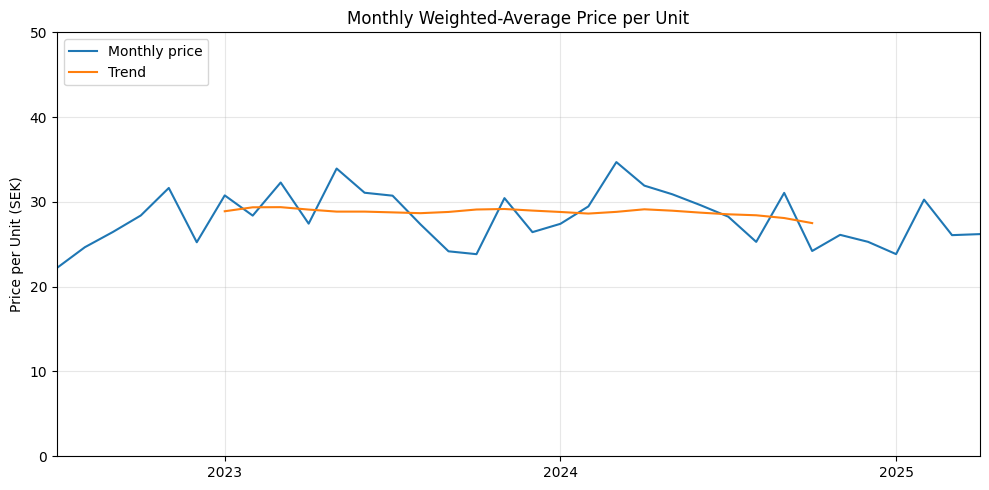

In [73]:
fig, ax = plt.subplots(figsize=(10, 5))

monthly_spend = df.groupby('month')['total_price'].sum()
monthly_qty = df.groupby('month')['quantity'].sum()
wavg_price = monthly_spend / monthly_qty

wavg_price.plot(ax=ax, label='Monthly price')
price_result = seasonal_decompose(wavg_price, model='additive', period=12)
price_result.trend.plot(ax=ax, label='Trend')

ax.set_ylabel('Price per Unit (SEK)')
ax.set_title('Monthly Weighted-Average Price per Unit')
ax.tick_params(axis='x', rotation=0)
ax.grid(alpha=0.3)
ax.legend(loc='upper left')

years = pd.date_range(start=df.datetime.min(), end=df.datetime.max(), freq='YS')
ax.set_xticks(years)
ax.set_xticklabels([d.strftime('%Y') for d in years])
ax.xaxis.set_minor_locator(plt.NullLocator())
ax.set_xlabel('')
ax.set_ylim(0, 50)

plt.tight_layout()
plt.savefig('data/output/monthly_weighted_average_price.png', dpi=300)
plt.show()